<a href="https://www.kaggle.com/code/averma111/simple-pk-fog?scriptVersionId=125099363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [26]:
tdcsfog_path='/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog'

In [27]:
## https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024 ** 2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [28]:
tdcsfog_list =[]
for file_name in os.listdir(tdcsfog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(tdcsfog_path, file_name)
        file = pd.read_csv(file_path)
        tdcsfog_list.append(file)

In [29]:
tdcsfog = pd.concat(tdcsfog_list, axis = 0)


In [30]:
tdcsfog=reduce_memory_usage(tdcsfog)

Memory usage of dataframe is 431.07 MB
Memory usage became:  141.4452667236328  MB


In [31]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [32]:
summary('tdcsfog',tdcsfog)

tdcsfog shape: (7062672, 7)


,dtypes,null,unique,min,median,max,mean,std
Time,int32,0,97077,0.000000,4310.000000,97076.000000,9289.467297,13998.925696
AccV,float16,0,4080,-35.531250,-9.367188,20.906250,NaN,0.000000
AccML,float16,0,30511,-26.171875,-0.172241,27.484375,NaN,0.000000
AccAP,float16,0,27751,-47.843750,1.987305,30.343750,NaN,0.000000
StartHesitation,int8,0,2,0.000000,0.000000,1.000000,0.043155,0.203206
Turn,int8,0,2,0.000000,0.000000,1.000000,0.237698,0.425673
Walking,int8,0,2,0.000000,0.000000,1.000000,0.029428,0.169002


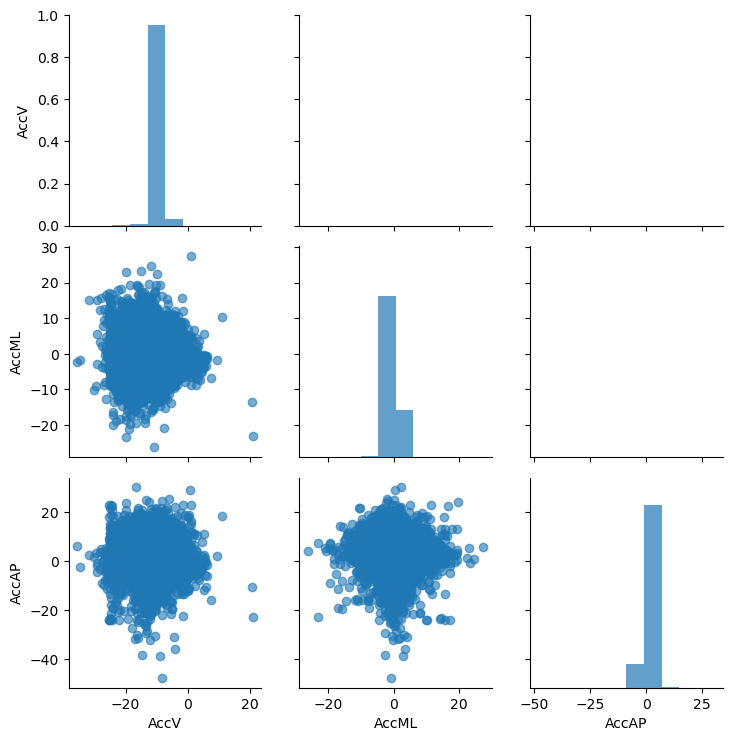

In [41]:
g = sns.PairGrid(tdcsfog[['AccV', 'AccML', 'AccAP']])
g.map_lower(plt.scatter, alpha = 0.6)
g.map_diag(plt.hist, alpha = 0.7)

In [48]:
X = tdcsfog.iloc[:, 1:4]  
y1 = tdcsfog['StartHesitation']  
y2 = tdcsfog['Turn']  
y3 = tdcsfog['Walking'] 

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_val, y1_train, y1_val = train_test_split(X, y1, test_size = 0.2, random_state = 52)
X_train, X_val, y2_train, y2_val  = train_test_split(X, y2, test_size = 0.2, random_state = 52)
X_train, X_val, y3_train, y3_val = train_test_split(X, y3, test_size = 0.2, random_state = 52)

In [56]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import  CatBoostRegressor

In [57]:
model_dict = {
    'Light GBM': LGBMRegressor(),
    'XG Boost' : XGBRegressor(),
    'Cat Boost' : CatBoostRegressor()
   
}

In [70]:
def evaluation(model_str, y_pred, y_pred_train,y_train):
    results = {
        'model': model_str,
        'classReport': classification_report(y_train,y_pred_train)
    }
    return results

In [ ]:
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y2_train)
    y2_pred = model_dict[model].predict(X_val)
    y2_pred_train = model_dict[model].predict(X_train)
    result = evaluation(model, y2_pred, y2_pred_train,y2_train)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)

In [ ]:
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y3_train)
    y3_pred = model_dict[model].predict(X_val)
    y_pred_train = model_dict[model].predict(X_train)
    result = evaluation(model, y3_pred, y3_pred_train,y3_train)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)